In [1]:
!pip install -U finance-datareader

     |████████████████████████████████| 48 kB 4.8 MB/s 


In [2]:
import numpy
import pandas as pd
import FinanceDataReader as fdr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import scipy.stats as ss

In [3]:
# 시가총액 순위 순으로
df_krx = fdr.StockListing("KRX-MARCAP")
df_krx.iloc[63]

Code                  035250
Name                    강원랜드
Market                 KOSPI
Dept                        
Close                  27150
ChangeCode                 1
Changes                  800
ChagesRatio             3.04
Open                   26700
High                   27500
Low                    26400
Volume                660551
Amount           17894741650
Marcap         5808484575000
Stocks             213940500
MarketId                 STK
Name: 64, dtype: object

In [4]:
item_code = "035250"
# item_code = "088980"
item_url = f"https://finance.naver.com/item/main.nhn?code={item_code}"
tables = pd.read_html(item_url, encoding="cp949")
print(tables[3])
print(tables[3].iloc[[10, 12], :0:-1].transpose())

       주요재무정보  최근 연간 실적                                최근 분기 실적            \
       주요재무정보   2019.12  2020.12   2021.12 2022.12(E)   2020.12   2021.03   
       주요재무정보    IFRS연결   IFRS연결    IFRS연결     IFRS연결    IFRS연결    IFRS연결   
0         매출액  15201.00     4786   7884.00   13439.00   1313.00    974.00   
1        영업이익   5012.00    -4316   -527.00    3047.00   -761.00   -596.00   
2       당기순이익   3347.00    -2759   -106.00    2389.00   -333.00   -409.00   
3       영업이익률     32.97   -90.18     -6.68      22.67    -57.96    -61.19   
4        순이익률     22.02   -57.65     -1.34      17.78    -25.39    -41.98   
5   ROE(지배주주)      9.16    -7.92     -0.33       7.14     -7.92     -4.88   
6        부채비율     19.38    12.15     17.66        NaN     12.15     12.30   
7        당좌비율    274.17   324.65    270.31        NaN    324.65    312.24   
8         유보율   3538.24  3098.20   3103.60        NaN   3098.20   3059.44   
9      EPS(원)   1564.00    -1289    -49.00    1116.00   -156.00   -191.00   

In [5]:
DF_SIZE = 1000

In [6]:
columns = ["Code", "Name", "PER", "PBR"]
df = pd.DataFrame(columns=columns)
for idx1, val1 in tqdm(df_krx.head(DF_SIZE).iterrows(), total=DF_SIZE):
    item_code = val1["Code"]
    item_url = f"https://finance.naver.com/item/main.nhn?code={item_code}"
    tables = pd.read_html(item_url, encoding="cp949")
    if len(tables[3]) < 13: continue
    for idx2, val2 in tables[3].iloc[[10, 12], :0:-1].transpose().iterrows():
        per = val2[10]
        pbr = val2[12]
        if (not pd.isna(per)) and (not pd.isna(pbr)):
            df = df.append({
                "Code": val1["Code"],
                "Name": val1["Name"],
                "PER": float(per),
                "PBR": float(pbr)
            }, ignore_index=True)
            break
df

  0%|          | 0/1000 [00:00<?, ?it/s]

,Code,Name,PER,PBR
0,005930,삼성전자,13.55,1.80
1,373220,LG에너지솔루션,99.07,4.95
2,000660,SK하이닉스,9.93,1.45
3,207940,삼성바이오로직스,151.83,11.97
4,005935,삼성전자우,13.55,1.80
...,...,...,...,...
976,301300,바이브컴퍼니,-32.75,9.16
977,239610,에이치엘사이언스,11.62,2.01
978,025320,시노펙스,20.38,2.27
979,006890,태경케미컬,13.13,0.99


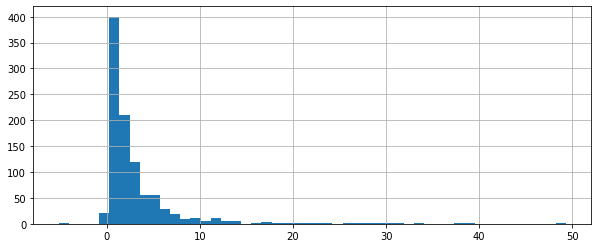

In [7]:
df["PBR"].hist(figsize=(10, 4), bins=50)

# 10.3.1 트림(Trim): 이상치 데이터 삭제
트림은 이상치 데이터를 삭제하는 방법입니다.

In [8]:
tmp_df = df.copy()
low = tmp_df["PBR"].quantile(0.05)
high = tmp_df["PBR"].quantile(0.95)
print(low, high)
tmp_df = tmp_df[(low <= tmp_df["PBR"]) & (tmp_df["PBR"] <= high)]

0.36 10.68


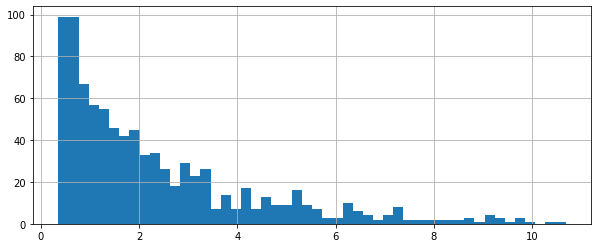

In [9]:
tmp_df["PBR"].hist(figsize=(10, 4), bins=50)

# 10.3.2 윈저라이징(Winsorizing): 이상치 데이터 대체
포트폴리오 구성에서는 일반적으로 이상치 데이터를 다른 데이터로 대체하는 윈저라이징 방법이 사용됩니다.

In [10]:
def winsorizing(PBR):
  if PBR < low:
    return low
  elif PBR > high:
    return high
  return PBR

In [11]:
tmp_df = df.copy()
tmp_df["PBR"] = tmp_df["PBR"].map(winsorizing)

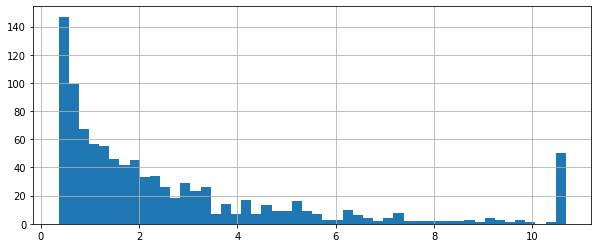

In [12]:
tmp_df["PBR"].hist(figsize=(10, 4), bins=50)

# 10.3.3 팩터의 결합 방법
밸류 지표의 결합, 퀄리티 지표의 결합, 마법공식 포트폴리오를 구성할 때 단순히 랭킹을 더하는 방법을 사용했습니다. 물론 투자 종목수가 얼마 되지 않거나, 개인 투자자의 입장에서는 이러한 방법이 가장 단순하면서도 효과적일수 있습니다. 그러나 전문투자자의 입장이거나 팩터를 분석하는 업무를 할 경우 이처럼 단순히 랭킹을 더하는 방법은 여러 가지 문제를 안고 있습니다.

In [13]:
df_per = df["PER"].rank()
df_pbr = df["PBR"].rank()

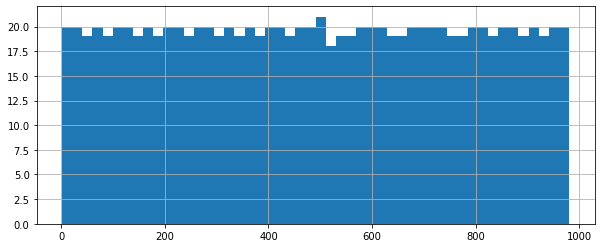

In [14]:
df_per.hist(figsize=(10, 4), bins=50)

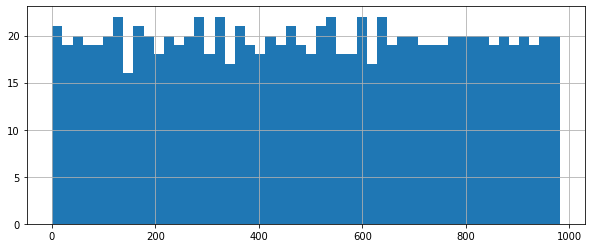

In [15]:
df_pbr.hist(figsize=(10, 4), bins=50)

그러나 각 지표의 x축을 보면 최댓값이 서로 다릅니다. 이는 지표별 결측치로 인해 유효 데이터의 개수가 달라 나타나는 현상이며, 서로 다른 범위의 분포를 단순히 합치는 것은 좋은 방법이 아닙니다. 예를 들어 A, B, C, D 팩터에 각각 비중을 40%, 30%, 20%, 10% 부여해 포트폴리오를 구성한다고 가정해봅시다. 각 랭킹은 분포의 범위가 다르므로, 랭킹과 비중의 가중평균을 통해 포트폴리오를 구성하면 왜곡된 결과를 발생시킵니다.

이러한 문제를 해결하는 가장 좋은 방법은 랭킹을 구한 후 이를 Z-Score로 정규화하는 것입니다.

Z
−
S
c
o
r
e
(
R
a
n
k
(
F
a
c
t
o
r
A
)
)
+
Z
−
S
c
o
r
e
(
R
a
n
k
(
F
a
c
t
o
r
B
)
)
+
…
+
Z
−
S
c
o
r
e
(
R
a
n
k
(
F
a
c
t
o
r
N
)
)

In [16]:
df_per = pd.Series(ss.zscore(df_per))
df_pbr = pd.Series(ss.zscore(df_pbr))

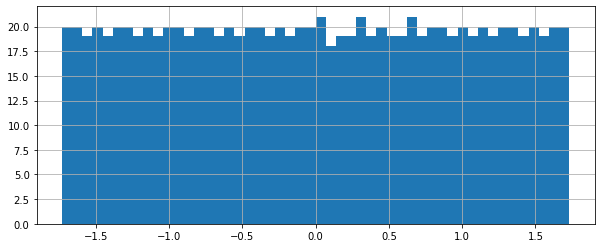

In [17]:
df_per.hist(figsize=(10, 4), bins=50)

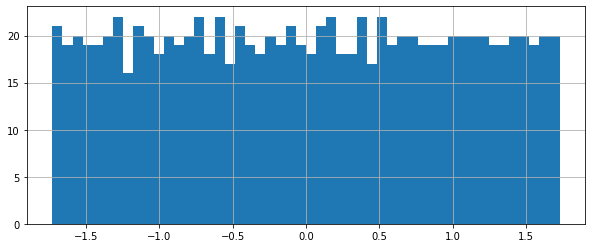

In [18]:
df_pbr.hist(figsize=(10, 4), bins=50)